In [39]:
!pip install torchvision numpy matplotlib tqdm tensorboard
from IPython import get_ipython
from IPython.display import display

import argparse
import os
import numpy as np
import math
import sys
from tqdm.auto import tqdm
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
import torchvision
from torch.autograd import Variable
import shutil

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt

current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')



#saved_loc = os.path.join('/content/drive/MyDrive/WGAN_Result', current_time)
#if os.path.exists(saved_loc):
#    shutil.rmtree(saved_loc)
#os.mkdir(saved_loc)

#image_loc = os.path.join(saved_loc, "images")
#os.mkdir(image_loc)
#weight_loc = os.path.join(saved_loc, "weights")
#os.mkdir(weight_loc)

#print("결과 저장 위치: ", saved_loc)
#print("이미지 저장 위치: ", image_loc)
#print("가중치 저장 위치: ", weight_loc)

#writer = SummaryWriter(saved_loc)

In [40]:
EPOCHS = 50
BATCH_SIZE = 128

transformation = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True, download = True,
                                            transform = transformation)

print("dataset size: ", len(train_dataset))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

latent_dim = 100

clip_value = 0.005
n_critic = 5
sample_interval = 400

img_shape = (1, 32, 32)

cuda = True if torch.cuda.is_available() else False

dataset size:  60000


In [41]:
class Generator(torch.nn.Module):
  """
  A deep convolutional generator network that generates images from a latent vector.

  Args:
      channels (int): Number of output channels (e.g., 3 for RGB images, 1 for grayscale).

  Example:
      >>> gen = Generator(channels=3)
      >>> noise = torch.randn(1, 100, 1, 1)  # Batch size of 1, latent vector of size 100
      >>> fake_image = gen(noise)
      >>> print(fake_image.shape)  # Expected output: torch.Size([1, 3, 32, 32])

  Returns:
      torch.Tensor: A generated image tensor with shape (batch_size, channels, 32, 32).
  """
  def __init__(self, channels):
    super().__init__()
    # Filters [1024, 512, 256]
    # Input_dim = 100
    # Output_dim = C (number of channels)
    self.main_module = nn.Sequential(
        # Z latent vector 100
        nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(True),

        # State (1024x4x4)
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(True),

        # State (512x8x8)
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(True),

        # State (256x16x16)
        nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
        # output of main module --> Image (Cx32x32)

    self.output = nn.Tanh()

  def forward(self, x):
    x = self.main_module(x)
    return self.output(x)

In [42]:
# Discriminator
class Discriminator(torch.nn.Module):
  """
  A deep convolutional discriminator network that evaluates whether an image is real or fake.

  Args:
      channels (int): Number of input channels (e.g., 3 for RGB images, 1 for grayscale).

  Example:
      >>> disc = Discriminator(channels=3)
      >>> fake_image = torch.randn(1, 3, 32, 32)  # Batch size of 1, 3-channel image (RGB)
      >>> result = disc(fake_image)
      >>> print(result.shape)  # Expected output: torch.Size([1, 1, 1, 1])

  Returns:
      torch.Tensor: A single value (logit) indicating whether the input image is real or fake.
  """
  def __init__(self, channels):
    super().__init__()
    # Filters [256, 512, 1024]
    # Input_dim = channels (Cx64x64)
    # Output_dim = 1
    self.main_module = nn.Sequential(
        # Image (Cx32x32)
        nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),

        # State (256x16x16)
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        # State (512x8x8)
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace=True))
        # outptut of main module --> State (1024x4x4)

    self.output = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
        # Output 1
        )

  # forward function moved inside the class
  def forward(self, x):
      x = self.main_module(x)
      return self.output(x)

In [43]:
# Initialize generator and discriminator
#generator = Generator(1)
#discriminator = Discriminator(1)

#if cuda:
#    generator.cuda()
#    discriminator.cuda()

#fixed_noise = torch.randn(16, 100, 1, 1).gpu()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

generator = Generator(1).to(device)
discriminator = Discriminator(1).to(device)

fixed_noise = torch.randn(16, 100, 1, 1, device=device)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00005)

Tensor = torch.cuda.FloatTensor if device.type == "cuda" else torch.FloatTensor

Using device: cuda


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 0/50] [Batch 0/469] [D loss: 0.180011] [G loss: 0.012468]


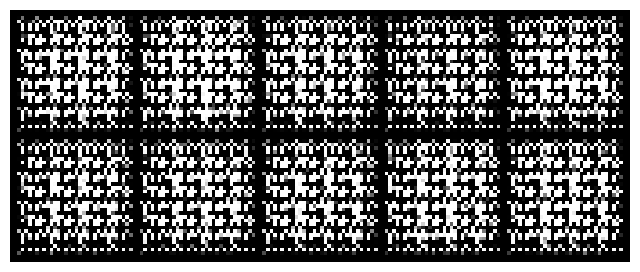

[Epoch 0/50] [Batch 100/469] [D loss: 0.300120] [G loss: 0.158511]
[Epoch 0/50] [Batch 200/469] [D loss: 0.187294] [G loss: 0.084745]
[Epoch 0/50] [Batch 300/469] [D loss: 0.299024] [G loss: 0.166953]
[Epoch 0/50] [Batch 400/469] [D loss: 0.429390] [G loss: 0.225065]


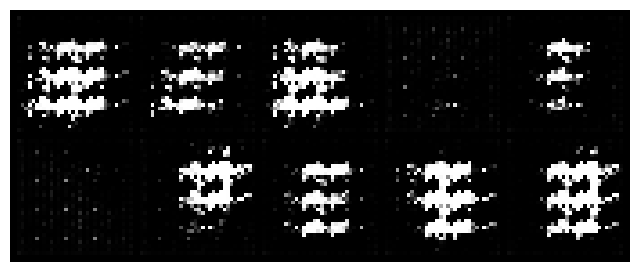

[Epoch 1/50] [Batch 31/469] [D loss: 0.385280] [G loss: 0.242146]
[Epoch 1/50] [Batch 131/469] [D loss: 0.428891] [G loss: 0.153742]
[Epoch 1/50] [Batch 231/469] [D loss: 0.455239] [G loss: 0.210587]
[Epoch 1/50] [Batch 331/469] [D loss: 0.448265] [G loss: 0.202986]


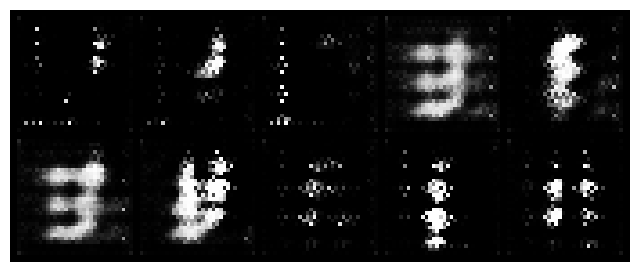

[Epoch 1/50] [Batch 431/469] [D loss: 0.404522] [G loss: 0.269435]
[Epoch 2/50] [Batch 62/469] [D loss: 0.366665] [G loss: 0.263517]
[Epoch 2/50] [Batch 162/469] [D loss: 0.534181] [G loss: 0.213263]
[Epoch 2/50] [Batch 262/469] [D loss: 0.416831] [G loss: 0.265223]


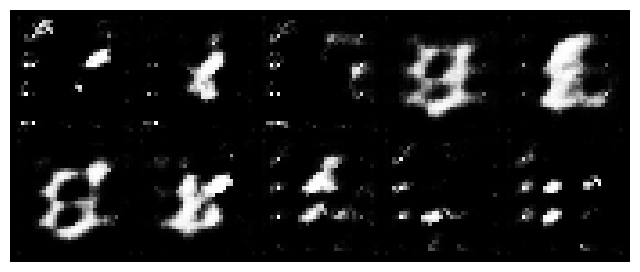

[Epoch 2/50] [Batch 362/469] [D loss: 0.401334] [G loss: 0.279113]
[Epoch 2/50] [Batch 462/469] [D loss: 0.383579] [G loss: 0.280046]
[Epoch 3/50] [Batch 93/469] [D loss: 0.389864] [G loss: 0.264522]
[Epoch 3/50] [Batch 193/469] [D loss: 0.286951] [G loss: 0.286735]


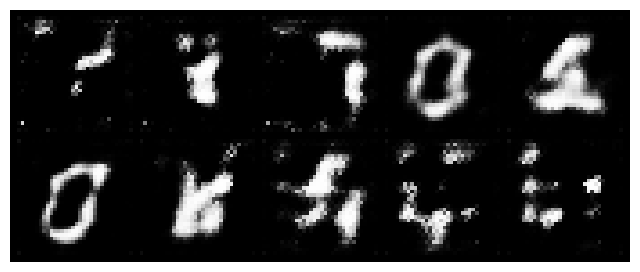

[Epoch 3/50] [Batch 293/469] [D loss: 0.351959] [G loss: 0.255795]
[Epoch 3/50] [Batch 393/469] [D loss: 0.417063] [G loss: 0.277491]
[Epoch 4/50] [Batch 24/469] [D loss: 0.551289] [G loss: 0.111897]
[Epoch 4/50] [Batch 124/469] [D loss: 0.285995] [G loss: 0.242024]


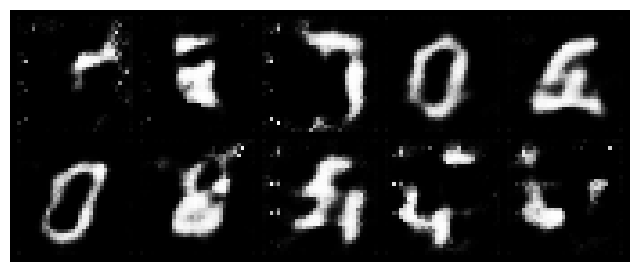

[Epoch 4/50] [Batch 224/469] [D loss: 0.388416] [G loss: 0.052029]
[Epoch 4/50] [Batch 324/469] [D loss: 0.383937] [G loss: 0.285561]
[Epoch 4/50] [Batch 424/469] [D loss: 0.359754] [G loss: 0.134667]
[Epoch 5/50] [Batch 55/469] [D loss: 0.356395] [G loss: 0.219068]


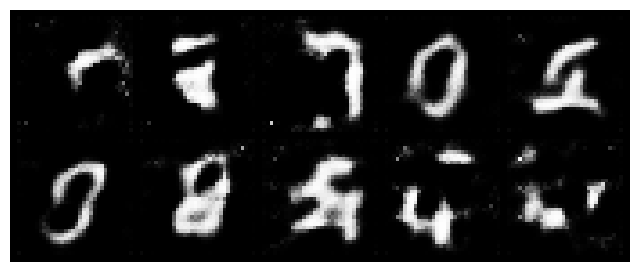

[Epoch 5/50] [Batch 155/469] [D loss: 0.294236] [G loss: 0.239631]
[Epoch 5/50] [Batch 255/469] [D loss: 0.309392] [G loss: 0.219371]
[Epoch 5/50] [Batch 355/469] [D loss: 0.267218] [G loss: 0.060955]
[Epoch 5/50] [Batch 455/469] [D loss: 0.437155] [G loss: 0.279857]


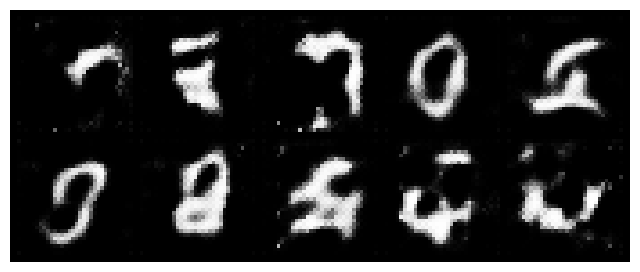

[Epoch 6/50] [Batch 86/469] [D loss: 0.275060] [G loss: 0.266879]
[Epoch 6/50] [Batch 186/469] [D loss: 0.253996] [G loss: 0.050443]
[Epoch 6/50] [Batch 286/469] [D loss: 0.258847] [G loss: 0.238857]
[Epoch 6/50] [Batch 386/469] [D loss: 0.229563] [G loss: 0.243650]


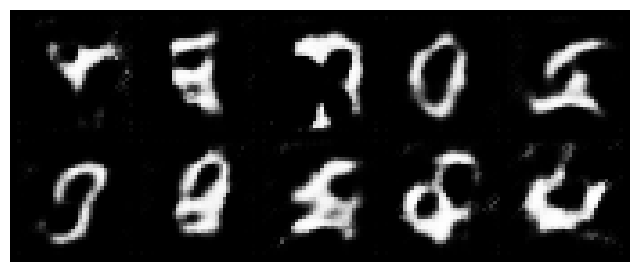

[Epoch 7/50] [Batch 17/469] [D loss: 0.225566] [G loss: 0.229359]
[Epoch 7/50] [Batch 117/469] [D loss: 0.294451] [G loss: 0.254104]
[Epoch 7/50] [Batch 217/469] [D loss: 0.389322] [G loss: 0.072398]
[Epoch 7/50] [Batch 317/469] [D loss: 0.290086] [G loss: 0.212114]


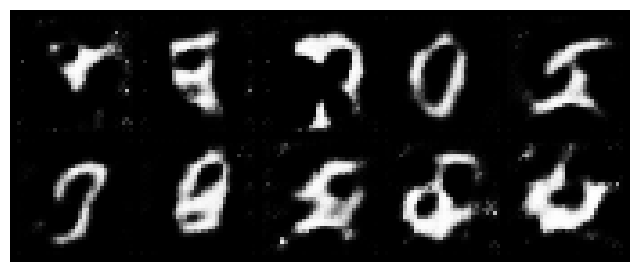

[Epoch 7/50] [Batch 417/469] [D loss: 0.272573] [G loss: 0.224142]
[Epoch 8/50] [Batch 48/469] [D loss: 0.271332] [G loss: 0.262765]
[Epoch 8/50] [Batch 148/469] [D loss: 0.258724] [G loss: 0.209084]
[Epoch 8/50] [Batch 248/469] [D loss: 0.242387] [G loss: 0.002373]


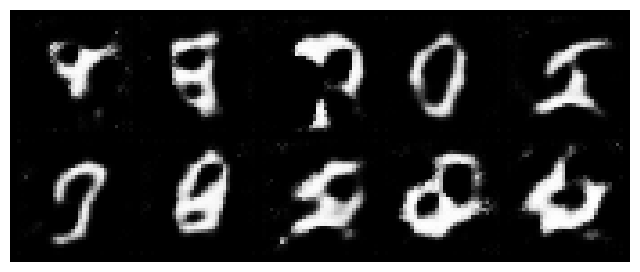

[Epoch 8/50] [Batch 348/469] [D loss: 0.428613] [G loss: 0.057117]
[Epoch 8/50] [Batch 448/469] [D loss: 0.266455] [G loss: 0.028271]
[Epoch 9/50] [Batch 79/469] [D loss: 0.281795] [G loss: 0.018616]
[Epoch 9/50] [Batch 179/469] [D loss: 0.291772] [G loss: 0.016001]


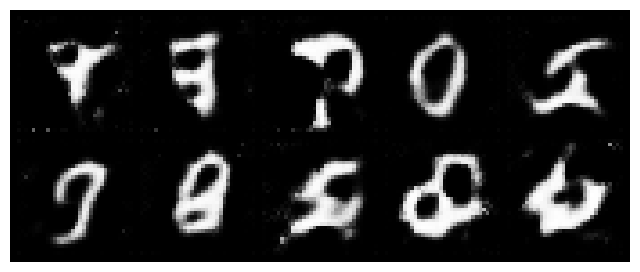

[Epoch 9/50] [Batch 279/469] [D loss: 0.268316] [G loss: 0.044588]
[Epoch 9/50] [Batch 379/469] [D loss: 0.412040] [G loss: 0.058621]
[Epoch 10/50] [Batch 10/469] [D loss: 0.339524] [G loss: 0.233906]
[Epoch 10/50] [Batch 110/469] [D loss: 0.221585] [G loss: 0.043333]


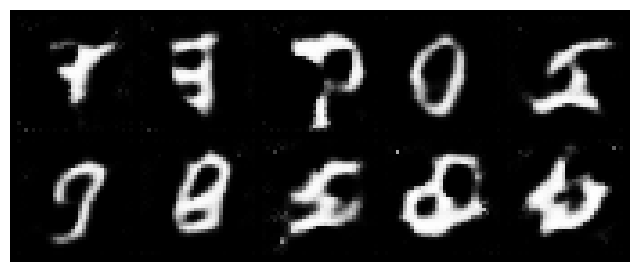

[Epoch 10/50] [Batch 210/469] [D loss: 0.238599] [G loss: 0.025561]
[Epoch 10/50] [Batch 310/469] [D loss: 0.292831] [G loss: 0.063573]
[Epoch 10/50] [Batch 410/469] [D loss: 0.241525] [G loss: 0.043620]
[Epoch 11/50] [Batch 41/469] [D loss: 0.288118] [G loss: 0.105347]


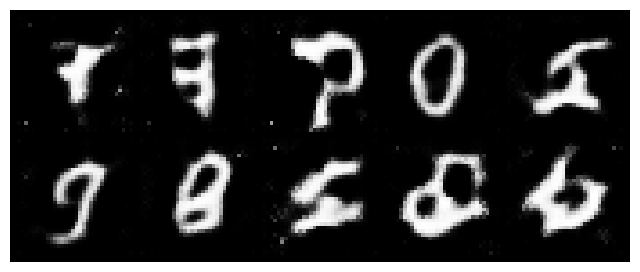

[Epoch 11/50] [Batch 141/469] [D loss: 0.230364] [G loss: 0.012997]
[Epoch 11/50] [Batch 241/469] [D loss: 0.292544] [G loss: 0.033808]
[Epoch 11/50] [Batch 341/469] [D loss: 0.214278] [G loss: 0.220863]
[Epoch 11/50] [Batch 441/469] [D loss: 0.263661] [G loss: 0.085489]


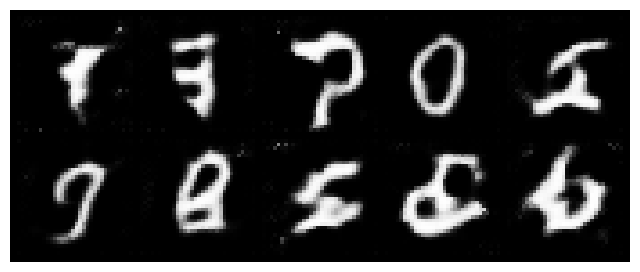

[Epoch 12/50] [Batch 72/469] [D loss: 0.248525] [G loss: 0.032155]
[Epoch 12/50] [Batch 172/469] [D loss: 0.225990] [G loss: 0.226596]
[Epoch 12/50] [Batch 272/469] [D loss: 0.233660] [G loss: 0.023590]
[Epoch 12/50] [Batch 372/469] [D loss: 0.261487] [G loss: 0.041930]


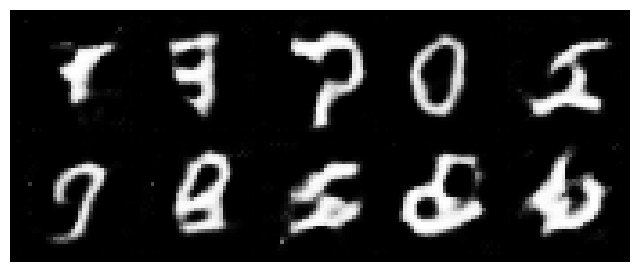

[Epoch 13/50] [Batch 3/469] [D loss: 0.300755] [G loss: 0.035081]
[Epoch 13/50] [Batch 103/469] [D loss: 0.227088] [G loss: 0.185830]
[Epoch 13/50] [Batch 203/469] [D loss: 0.213120] [G loss: 0.202629]
[Epoch 13/50] [Batch 303/469] [D loss: 0.229984] [G loss: 0.105009]


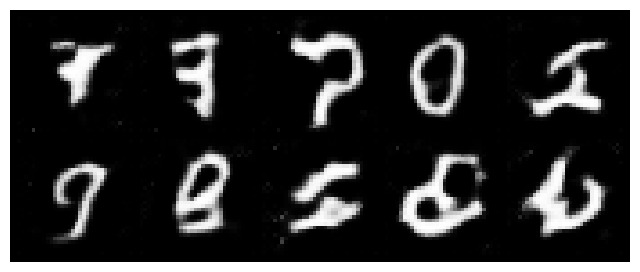

[Epoch 13/50] [Batch 403/469] [D loss: 0.233226] [G loss: 0.068561]
[Epoch 14/50] [Batch 34/469] [D loss: 0.216628] [G loss: 0.196299]
[Epoch 14/50] [Batch 134/469] [D loss: 0.258099] [G loss: 0.055534]
[Epoch 14/50] [Batch 234/469] [D loss: 0.206373] [G loss: 0.223150]


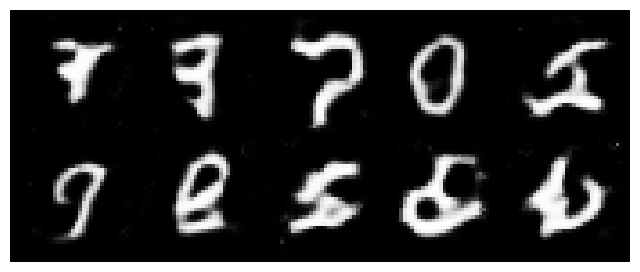

[Epoch 14/50] [Batch 334/469] [D loss: 0.205135] [G loss: 0.245865]
[Epoch 14/50] [Batch 434/469] [D loss: 0.260263] [G loss: 0.054865]
[Epoch 15/50] [Batch 65/469] [D loss: 0.202523] [G loss: 0.054006]
[Epoch 15/50] [Batch 165/469] [D loss: 0.255589] [G loss: 0.141860]


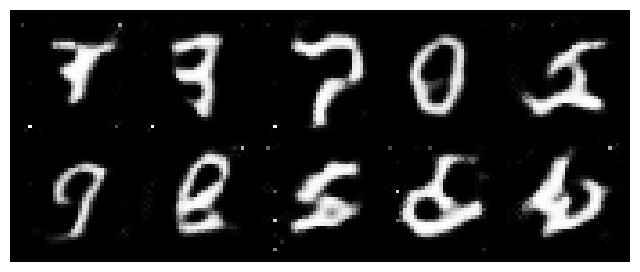

[Epoch 15/50] [Batch 265/469] [D loss: 0.199055] [G loss: 0.038202]
[Epoch 15/50] [Batch 365/469] [D loss: 0.256666] [G loss: 0.064401]
[Epoch 15/50] [Batch 465/469] [D loss: 0.232965] [G loss: 0.216487]
[Epoch 16/50] [Batch 96/469] [D loss: 0.208531] [G loss: 0.031632]


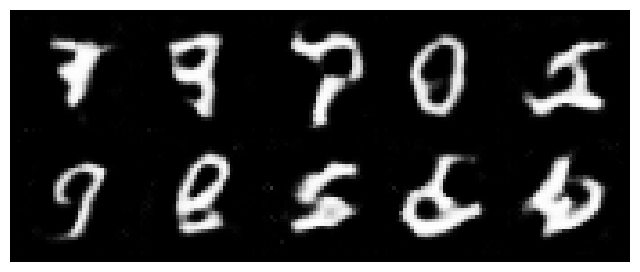

[Epoch 16/50] [Batch 196/469] [D loss: 0.194908] [G loss: 0.178953]
[Epoch 16/50] [Batch 296/469] [D loss: 0.216617] [G loss: 0.050225]
[Epoch 16/50] [Batch 396/469] [D loss: 0.249545] [G loss: -0.004549]
[Epoch 17/50] [Batch 27/469] [D loss: 0.237673] [G loss: 0.190472]


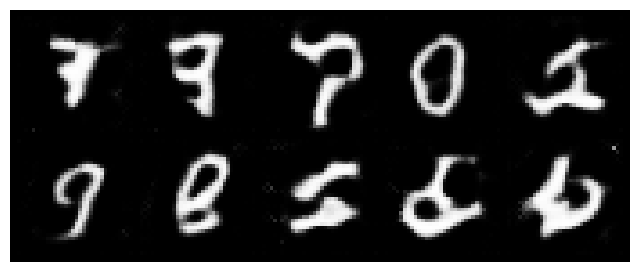

[Epoch 17/50] [Batch 127/469] [D loss: 0.211284] [G loss: 0.162748]
[Epoch 17/50] [Batch 227/469] [D loss: 0.179575] [G loss: 0.225236]
[Epoch 17/50] [Batch 327/469] [D loss: 0.286979] [G loss: 0.044981]
[Epoch 17/50] [Batch 427/469] [D loss: 0.238979] [G loss: 0.043793]


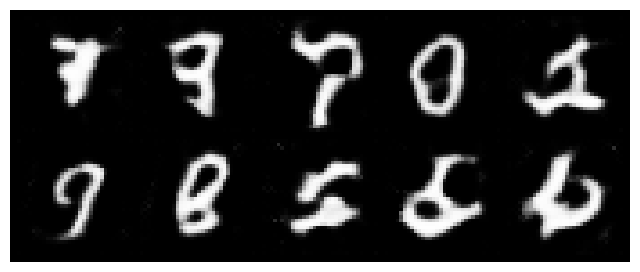

[Epoch 18/50] [Batch 58/469] [D loss: 0.216535] [G loss: 0.204910]
[Epoch 18/50] [Batch 158/469] [D loss: 0.211312] [G loss: 0.216812]
[Epoch 18/50] [Batch 258/469] [D loss: 0.182012] [G loss: 0.205179]
[Epoch 18/50] [Batch 358/469] [D loss: 0.240745] [G loss: 0.247997]


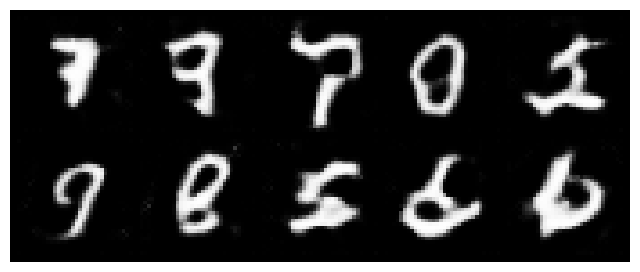

[Epoch 18/50] [Batch 458/469] [D loss: 0.200727] [G loss: 0.217181]
[Epoch 19/50] [Batch 89/469] [D loss: 0.225352] [G loss: 0.010021]
[Epoch 19/50] [Batch 189/469] [D loss: 0.238953] [G loss: 0.050842]
[Epoch 19/50] [Batch 289/469] [D loss: 0.277840] [G loss: 0.156963]


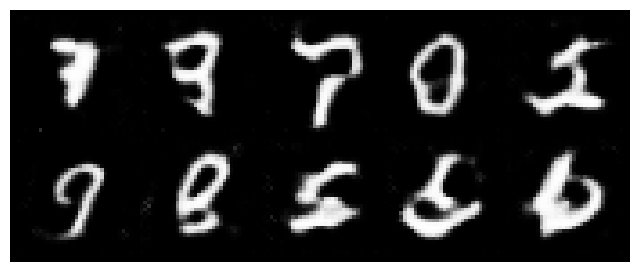

[Epoch 19/50] [Batch 389/469] [D loss: 0.206748] [G loss: 0.071535]
[Epoch 20/50] [Batch 20/469] [D loss: 0.187832] [G loss: 0.038281]
[Epoch 20/50] [Batch 120/469] [D loss: 0.225939] [G loss: -0.041988]
[Epoch 20/50] [Batch 220/469] [D loss: 0.208356] [G loss: 0.048491]


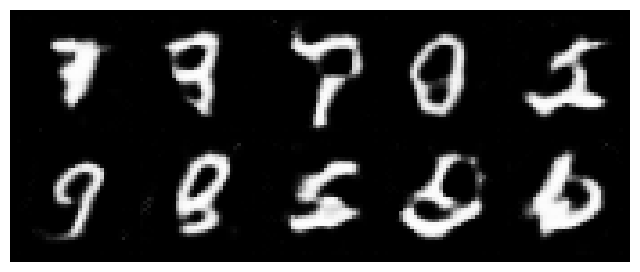

[Epoch 20/50] [Batch 320/469] [D loss: 0.203455] [G loss: 0.047349]
[Epoch 20/50] [Batch 420/469] [D loss: 0.219079] [G loss: 0.164275]
[Epoch 21/50] [Batch 51/469] [D loss: 0.159588] [G loss: 0.048980]
[Epoch 21/50] [Batch 151/469] [D loss: 0.233503] [G loss: 0.037296]


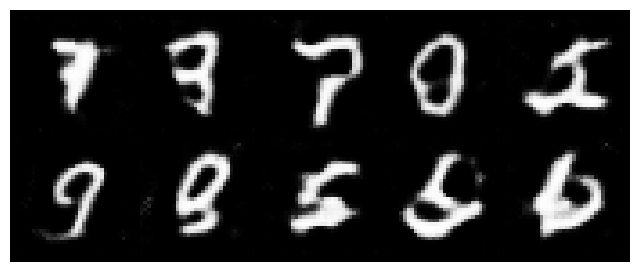

[Epoch 21/50] [Batch 251/469] [D loss: 0.186367] [G loss: 0.185685]
[Epoch 21/50] [Batch 351/469] [D loss: 0.174363] [G loss: 0.212018]
[Epoch 21/50] [Batch 451/469] [D loss: 0.219102] [G loss: 0.258233]
[Epoch 22/50] [Batch 82/469] [D loss: 0.189140] [G loss: 0.070123]


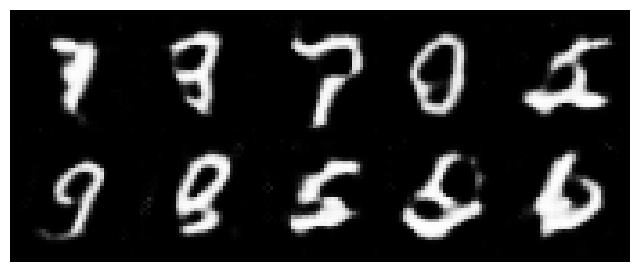

[Epoch 22/50] [Batch 182/469] [D loss: 0.194074] [G loss: 0.030969]
[Epoch 22/50] [Batch 282/469] [D loss: 0.259658] [G loss: 0.118809]
[Epoch 22/50] [Batch 382/469] [D loss: 0.232799] [G loss: 0.041973]
[Epoch 23/50] [Batch 13/469] [D loss: 0.181534] [G loss: 0.224745]


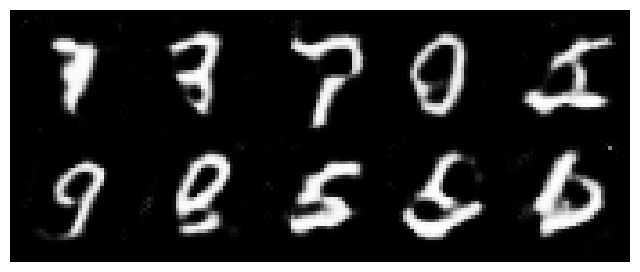

[Epoch 23/50] [Batch 113/469] [D loss: 0.161564] [G loss: 0.276262]
[Epoch 23/50] [Batch 213/469] [D loss: 0.173290] [G loss: 0.235256]
[Epoch 23/50] [Batch 313/469] [D loss: 0.246504] [G loss: 0.005417]
[Epoch 23/50] [Batch 413/469] [D loss: 0.199918] [G loss: 0.157211]


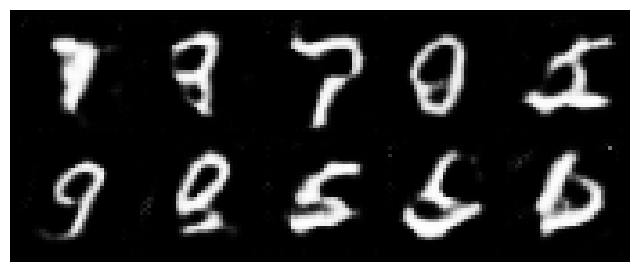

[Epoch 24/50] [Batch 44/469] [D loss: 0.232659] [G loss: 0.019950]
[Epoch 24/50] [Batch 144/469] [D loss: 0.234147] [G loss: -0.005695]
[Epoch 24/50] [Batch 244/469] [D loss: 0.277856] [G loss: 0.007864]
[Epoch 24/50] [Batch 344/469] [D loss: 0.223207] [G loss: 0.009496]


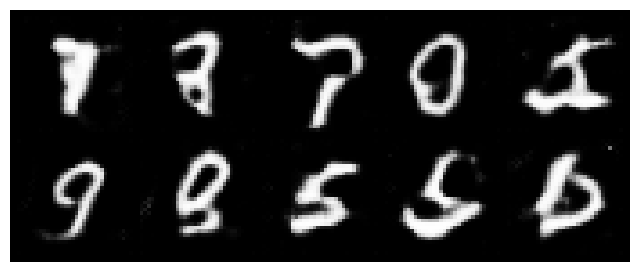

[Epoch 24/50] [Batch 444/469] [D loss: 0.233857] [G loss: 0.084557]
[Epoch 25/50] [Batch 75/469] [D loss: 0.232606] [G loss: 0.220598]
[Epoch 25/50] [Batch 175/469] [D loss: 0.254753] [G loss: 0.234921]
[Epoch 25/50] [Batch 275/469] [D loss: 0.199060] [G loss: -0.007050]


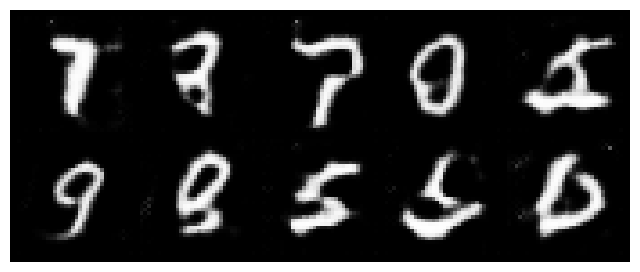

[Epoch 25/50] [Batch 375/469] [D loss: 0.182773] [G loss: 0.217671]
[Epoch 26/50] [Batch 6/469] [D loss: 0.185924] [G loss: -0.026912]
[Epoch 26/50] [Batch 106/469] [D loss: 0.151535] [G loss: 0.200046]
[Epoch 26/50] [Batch 206/469] [D loss: 0.134051] [G loss: 0.236237]


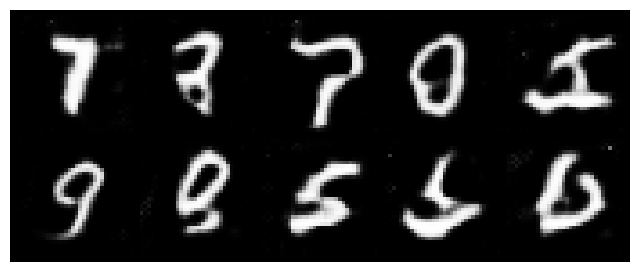

[Epoch 26/50] [Batch 306/469] [D loss: 0.135343] [G loss: 0.234786]
[Epoch 26/50] [Batch 406/469] [D loss: 0.191807] [G loss: 0.260535]
[Epoch 27/50] [Batch 37/469] [D loss: 0.176117] [G loss: 0.209596]
[Epoch 27/50] [Batch 137/469] [D loss: 0.237740] [G loss: 0.185688]


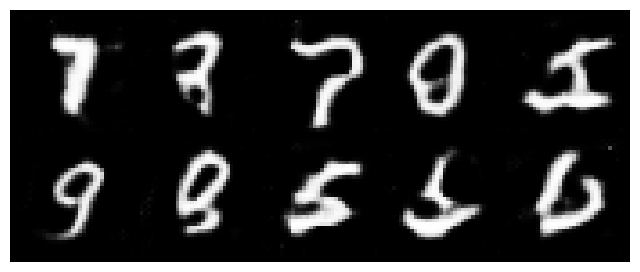

[Epoch 27/50] [Batch 237/469] [D loss: 0.197510] [G loss: 0.241915]
[Epoch 27/50] [Batch 337/469] [D loss: 0.212778] [G loss: 0.037366]
[Epoch 27/50] [Batch 437/469] [D loss: 0.150482] [G loss: 0.225358]
[Epoch 28/50] [Batch 68/469] [D loss: 0.184314] [G loss: 0.063462]


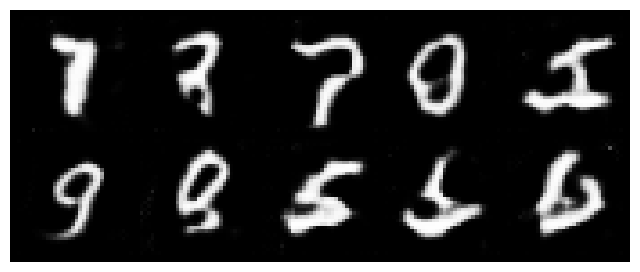

[Epoch 28/50] [Batch 168/469] [D loss: 0.150989] [G loss: 0.011896]
[Epoch 28/50] [Batch 268/469] [D loss: 0.205179] [G loss: -0.043924]
[Epoch 28/50] [Batch 368/469] [D loss: 0.264094] [G loss: -0.003304]
[Epoch 28/50] [Batch 468/469] [D loss: 0.199210] [G loss: 0.059186]


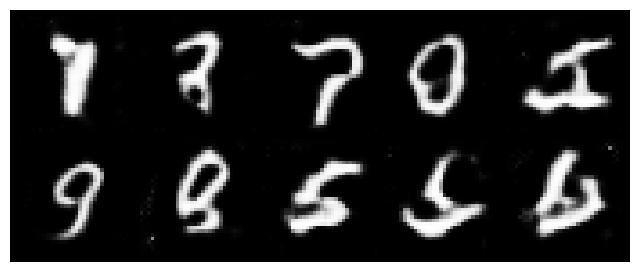

[Epoch 29/50] [Batch 99/469] [D loss: 0.152198] [G loss: 0.152152]
[Epoch 29/50] [Batch 199/469] [D loss: 0.164264] [G loss: 0.229799]
[Epoch 29/50] [Batch 299/469] [D loss: 0.159972] [G loss: 0.232994]
[Epoch 29/50] [Batch 399/469] [D loss: 0.201232] [G loss: 0.191105]


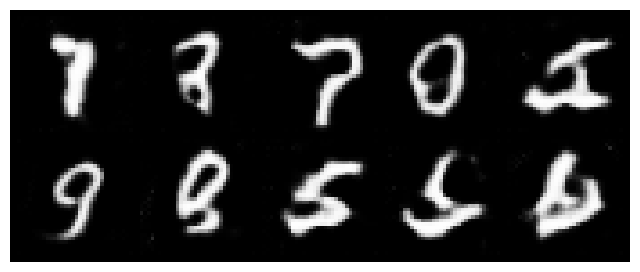

[Epoch 30/50] [Batch 30/469] [D loss: 0.169965] [G loss: 0.189220]
[Epoch 30/50] [Batch 130/469] [D loss: 0.174631] [G loss: 0.203281]
[Epoch 30/50] [Batch 230/469] [D loss: 0.174048] [G loss: 0.067913]
[Epoch 30/50] [Batch 330/469] [D loss: 0.193336] [G loss: 0.213883]


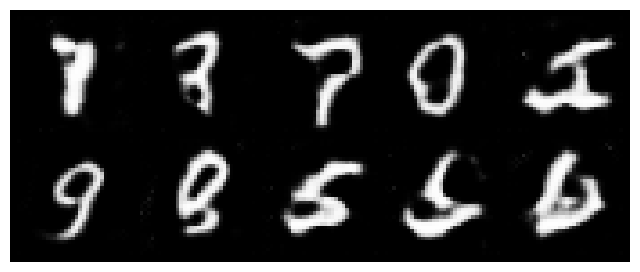

[Epoch 30/50] [Batch 430/469] [D loss: 0.207885] [G loss: 0.246828]
[Epoch 31/50] [Batch 61/469] [D loss: 0.192333] [G loss: 0.054241]
[Epoch 31/50] [Batch 161/469] [D loss: 0.232452] [G loss: 0.016870]
[Epoch 31/50] [Batch 261/469] [D loss: 0.133491] [G loss: 0.231349]


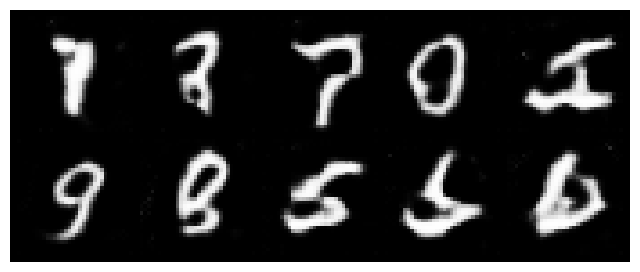

[Epoch 31/50] [Batch 361/469] [D loss: 0.114501] [G loss: 0.230481]
[Epoch 31/50] [Batch 461/469] [D loss: 0.110729] [G loss: 0.206917]
[Epoch 32/50] [Batch 92/469] [D loss: 0.192470] [G loss: 0.053860]
[Epoch 32/50] [Batch 192/469] [D loss: 0.184274] [G loss: -0.041097]


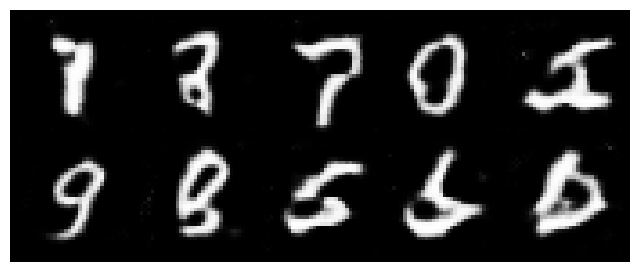

[Epoch 32/50] [Batch 292/469] [D loss: 0.133715] [G loss: 0.252633]
[Epoch 32/50] [Batch 392/469] [D loss: 0.244145] [G loss: -0.057631]
[Epoch 33/50] [Batch 23/469] [D loss: 0.266918] [G loss: 0.012228]
[Epoch 33/50] [Batch 123/469] [D loss: 0.186814] [G loss: 0.075124]


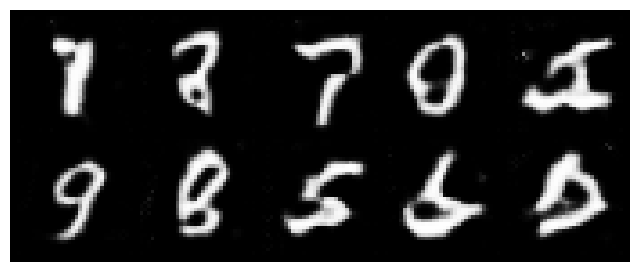

[Epoch 33/50] [Batch 223/469] [D loss: 0.179093] [G loss: 0.004927]
[Epoch 33/50] [Batch 323/469] [D loss: 0.221899] [G loss: -0.014896]
[Epoch 33/50] [Batch 423/469] [D loss: 0.182473] [G loss: 0.248206]
[Epoch 34/50] [Batch 54/469] [D loss: 0.175861] [G loss: 0.039201]


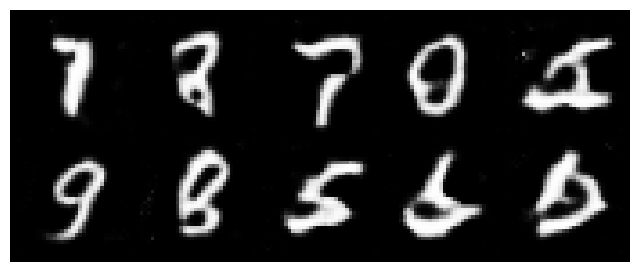

[Epoch 34/50] [Batch 154/469] [D loss: 0.162967] [G loss: 0.208325]
[Epoch 34/50] [Batch 254/469] [D loss: 0.159805] [G loss: 0.236397]
[Epoch 34/50] [Batch 354/469] [D loss: 0.198537] [G loss: 0.017183]
[Epoch 34/50] [Batch 454/469] [D loss: 0.158353] [G loss: 0.206394]


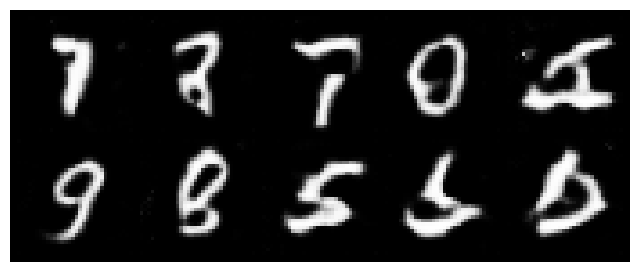

[Epoch 35/50] [Batch 85/469] [D loss: 0.185232] [G loss: -0.000060]
[Epoch 35/50] [Batch 185/469] [D loss: 0.171965] [G loss: 0.196378]
[Epoch 35/50] [Batch 285/469] [D loss: 0.182791] [G loss: -0.061399]
[Epoch 35/50] [Batch 385/469] [D loss: 0.191241] [G loss: -0.002169]


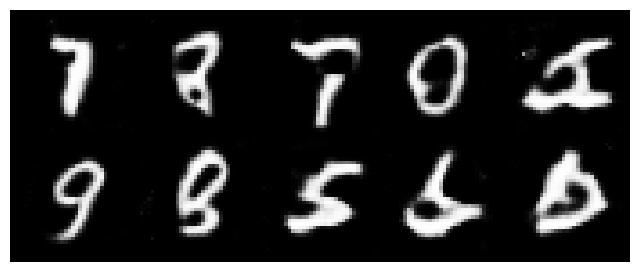

[Epoch 36/50] [Batch 16/469] [D loss: 0.173282] [G loss: 0.232333]
[Epoch 36/50] [Batch 116/469] [D loss: 0.132682] [G loss: 0.180504]
[Epoch 36/50] [Batch 216/469] [D loss: 0.137194] [G loss: 0.007977]
[Epoch 36/50] [Batch 316/469] [D loss: 0.109385] [G loss: 0.197073]


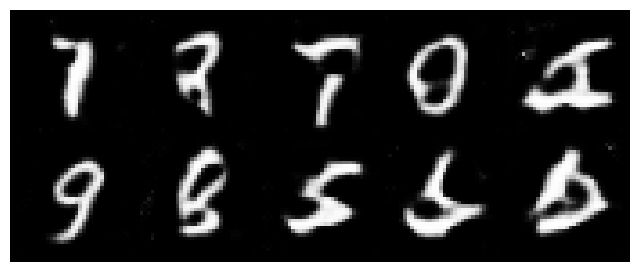

[Epoch 36/50] [Batch 416/469] [D loss: 0.146688] [G loss: 0.051170]
[Epoch 37/50] [Batch 47/469] [D loss: 0.155611] [G loss: 0.225592]
[Epoch 37/50] [Batch 147/469] [D loss: 0.153734] [G loss: 0.209597]
[Epoch 37/50] [Batch 247/469] [D loss: 0.150279] [G loss: 0.229199]


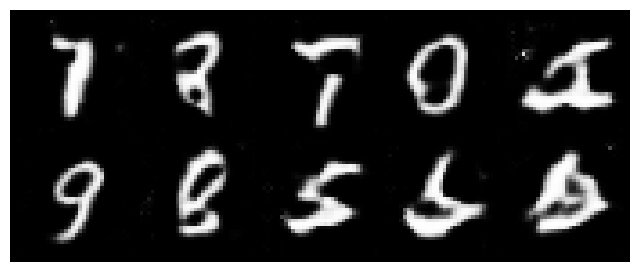

[Epoch 37/50] [Batch 347/469] [D loss: 0.171193] [G loss: -0.065428]
[Epoch 37/50] [Batch 447/469] [D loss: 0.170225] [G loss: -0.013247]
[Epoch 38/50] [Batch 78/469] [D loss: 0.171767] [G loss: 0.114816]
[Epoch 38/50] [Batch 178/469] [D loss: 0.147185] [G loss: 0.227555]


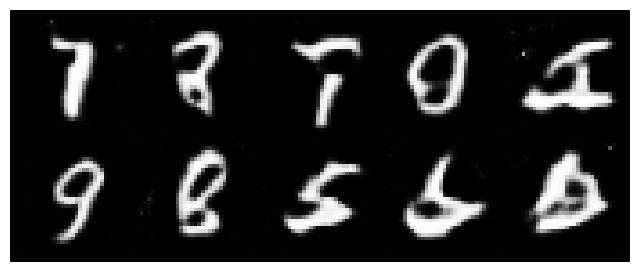

[Epoch 38/50] [Batch 278/469] [D loss: 0.175975] [G loss: 0.086458]
[Epoch 38/50] [Batch 378/469] [D loss: 0.164370] [G loss: 0.164790]
[Epoch 39/50] [Batch 9/469] [D loss: 0.216516] [G loss: 0.061540]
[Epoch 39/50] [Batch 109/469] [D loss: 0.160187] [G loss: 0.204782]


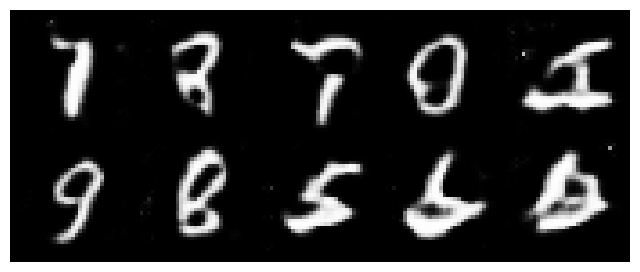

[Epoch 39/50] [Batch 209/469] [D loss: 0.184354] [G loss: 0.181488]
[Epoch 39/50] [Batch 309/469] [D loss: 0.177250] [G loss: -0.023503]
[Epoch 39/50] [Batch 409/469] [D loss: 0.232767] [G loss: -0.046932]
[Epoch 40/50] [Batch 40/469] [D loss: 0.198398] [G loss: 0.253386]


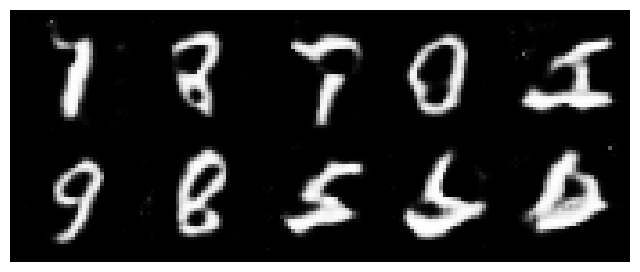

[Epoch 40/50] [Batch 140/469] [D loss: 0.209898] [G loss: 0.259349]
[Epoch 40/50] [Batch 240/469] [D loss: 0.174566] [G loss: 0.230485]
[Epoch 40/50] [Batch 340/469] [D loss: 0.165426] [G loss: 0.038625]
[Epoch 40/50] [Batch 440/469] [D loss: 0.153218] [G loss: 0.103662]


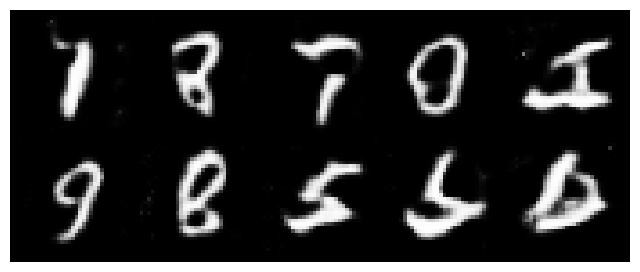

[Epoch 41/50] [Batch 71/469] [D loss: 0.151320] [G loss: 0.055914]
[Epoch 41/50] [Batch 171/469] [D loss: 0.104722] [G loss: 0.237111]
[Epoch 41/50] [Batch 271/469] [D loss: 0.123647] [G loss: 0.184453]
[Epoch 41/50] [Batch 371/469] [D loss: 0.133124] [G loss: 0.007662]


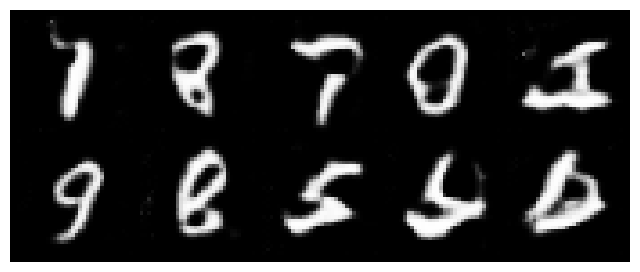

[Epoch 42/50] [Batch 2/469] [D loss: 0.149298] [G loss: -0.058075]
[Epoch 42/50] [Batch 102/469] [D loss: 0.199798] [G loss: 0.004825]
[Epoch 42/50] [Batch 202/469] [D loss: 0.199790] [G loss: 0.061792]
[Epoch 42/50] [Batch 302/469] [D loss: 0.154266] [G loss: -0.020669]


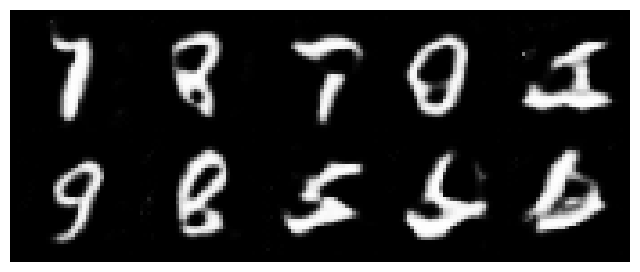

[Epoch 42/50] [Batch 402/469] [D loss: 0.186228] [G loss: 0.047823]
[Epoch 43/50] [Batch 33/469] [D loss: 0.158072] [G loss: -0.030933]
[Epoch 43/50] [Batch 133/469] [D loss: 0.150964] [G loss: -0.031832]
[Epoch 43/50] [Batch 233/469] [D loss: 0.164796] [G loss: 0.041478]


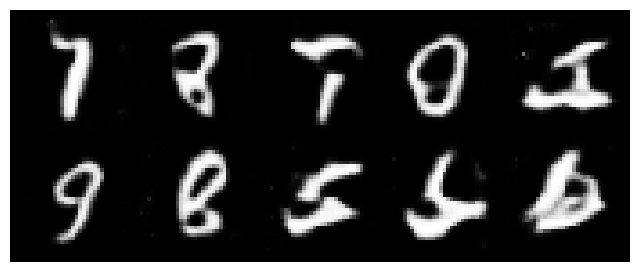

[Epoch 43/50] [Batch 333/469] [D loss: 0.163000] [G loss: -0.057259]
[Epoch 43/50] [Batch 433/469] [D loss: 0.181291] [G loss: -0.061111]
[Epoch 44/50] [Batch 64/469] [D loss: 0.146148] [G loss: 0.224556]
[Epoch 44/50] [Batch 164/469] [D loss: 0.172150] [G loss: 0.030123]


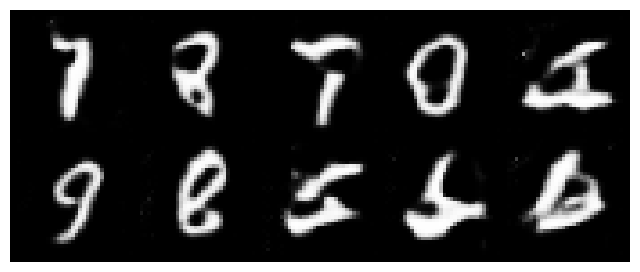

[Epoch 44/50] [Batch 264/469] [D loss: 0.218838] [G loss: 0.002062]
[Epoch 44/50] [Batch 364/469] [D loss: 0.150219] [G loss: -0.038639]
[Epoch 44/50] [Batch 464/469] [D loss: 0.175395] [G loss: 0.155058]
[Epoch 45/50] [Batch 95/469] [D loss: 0.143738] [G loss: 0.176557]


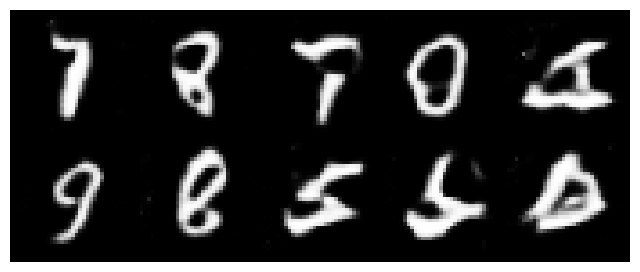

[Epoch 45/50] [Batch 195/469] [D loss: 0.141675] [G loss: -0.040438]
[Epoch 45/50] [Batch 295/469] [D loss: 0.157740] [G loss: 0.181965]
[Epoch 45/50] [Batch 395/469] [D loss: 0.125263] [G loss: 0.165237]
[Epoch 46/50] [Batch 26/469] [D loss: 0.151925] [G loss: 0.044462]


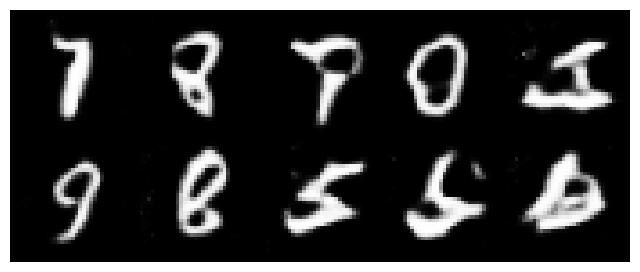

[Epoch 46/50] [Batch 126/469] [D loss: 0.104929] [G loss: 0.222486]
[Epoch 46/50] [Batch 226/469] [D loss: 0.133836] [G loss: -0.020291]
[Epoch 46/50] [Batch 326/469] [D loss: 0.138646] [G loss: 0.004781]
[Epoch 46/50] [Batch 426/469] [D loss: 0.110359] [G loss: -0.041127]


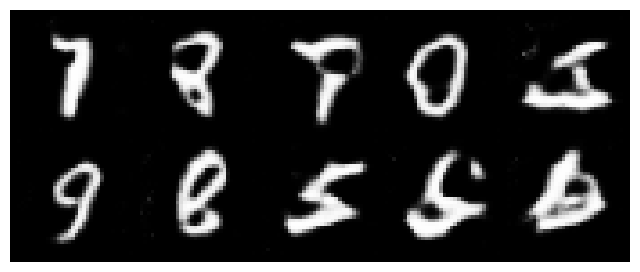

[Epoch 47/50] [Batch 57/469] [D loss: 0.201332] [G loss: 0.013800]
[Epoch 47/50] [Batch 157/469] [D loss: 0.181588] [G loss: -0.026867]
[Epoch 47/50] [Batch 257/469] [D loss: 0.207892] [G loss: -0.066840]
[Epoch 47/50] [Batch 357/469] [D loss: 0.174460] [G loss: 0.016977]


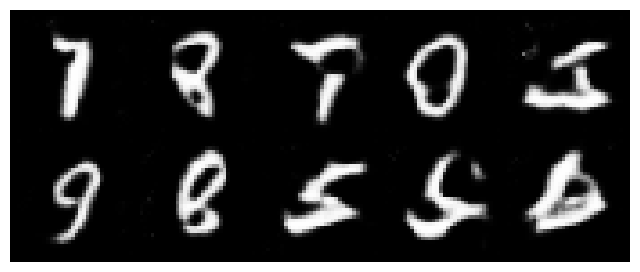

[Epoch 47/50] [Batch 457/469] [D loss: 0.118461] [G loss: 0.217437]
[Epoch 48/50] [Batch 88/469] [D loss: 0.168227] [G loss: -0.066270]
[Epoch 48/50] [Batch 188/469] [D loss: 0.179824] [G loss: 0.167901]
[Epoch 48/50] [Batch 288/469] [D loss: 0.155808] [G loss: 0.181965]


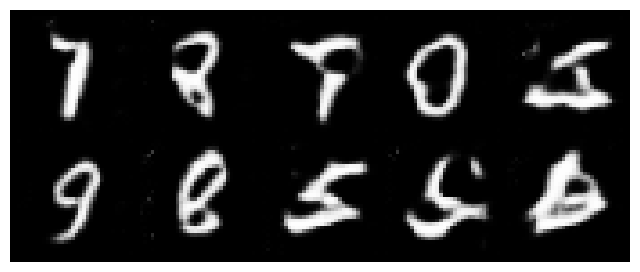

[Epoch 48/50] [Batch 388/469] [D loss: 0.205347] [G loss: 0.165926]
[Epoch 49/50] [Batch 19/469] [D loss: 0.132329] [G loss: 0.161645]
[Epoch 49/50] [Batch 119/469] [D loss: 0.147264] [G loss: 0.015857]
[Epoch 49/50] [Batch 219/469] [D loss: 0.173196] [G loss: -0.057186]


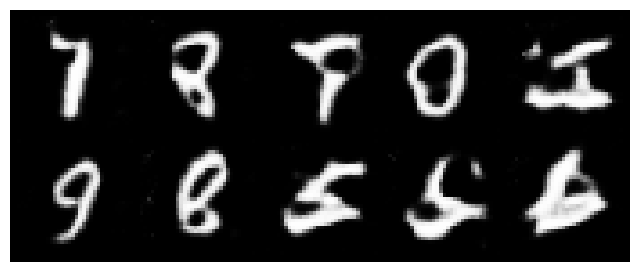

[Epoch 49/50] [Batch 319/469] [D loss: 0.197641] [G loss: -0.029894]
[Epoch 49/50] [Batch 419/469] [D loss: 0.143185] [G loss: 0.233426]


In [44]:
#  Training
# ----------

batches_done = 0
for epoch in tqdm(range(EPOCHS)):

    D_losses = []
    G_losses = []

    for i, (imgs, _) in enumerate(trainloader):

        # Configure input
        # real_imgs = Variable(imgs.type(Tensor))
        real_imgs = imgs.to(device, dtype=torch.float)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim, 1, 1))))
        z = torch.randn(imgs.shape[0], latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
        """
        Args:
            real_imgs (torch.Tensor): A batch of real images from the dataset.
            fake_imgs (torch.Tensor): A batch of fake images generated by the generator.
            discriminator (nn.Module): The discriminator model that evaluates images.

        Example:
            real_imgs = Variable(imgs.type(Tensor))
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim, 1, 1))))
            fake_imgs = generator(z).detach()
            loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        Result:
            loss_D (torch.Tensor): The Wasserstein loss for the discriminator, which is used to update the model.
        """

        #writer.add_scalar("Train/Wasserstein_estimate", -loss_D.item(), batches_done)

        loss_D.backward()
        optimizer_D.step()

        D_losses.append(-loss_D.item())

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            # writer.add_scalar("Train/Generator_loss", loss_G.item(), batches_done // n_critic)

            """
            Args:
                gen_imgs (torch.Tensor): A batch of images generated by the generator.
                discriminator (nn.Module): The discriminator model that evaluates images.

            Example:
                gen_imgs = generator(z)
                loss_G = -torch.mean(discriminator(gen_imgs))

            Result:
                loss_G (torch.Tensor): The loss for the generator, which is used to update the model.
            """

            G_losses.append(loss_G.item())

            loss_G.backward()
            optimizer_G.step()


        if batches_done % 100 == 0:
             print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, batches_done % len(trainloader), len(trainloader), -loss_D.item(), loss_G.item())
            )


        if batches_done % sample_interval == 0:
            fake = generator(fixed_noise).cpu()
            #save_image(fake.data[:10], os.path.join(image_loc, "fake_samples_epoch_%03d_index_%03d.png" % (epoch, i)), nrow=5, normalize=True)
            # Show the image in Colab
            grid_img = torchvision.utils.make_grid(fake[:10], nrow=5, normalize=True)
            npimg = grid_img.permute(1, 2, 0).numpy()

            plt.figure(figsize=(8, 4))
            plt.imshow(npimg)
            plt.axis("off")
            plt.show()
        batches_done += 1


    #torch.save(generator.state_dict(), '%s/Generator_epoch_%d.pth' % (weight_loc, epoch))
    #torch.save(discriminator.state_dict(), '%s/Discriminator_epoch_%d.pth' % (weight_loc, epoch))

    D_loss_epoch = torch.mean(torch.FloatTensor(D_losses))
    G_loss_epoch = torch.mean(torch.FloatTensor(G_losses))
    #writer.add_scalars('Train/loss per epoch', {'Average Wasserstein estimate per epoch' : D_loss_epoch.item(),
    #                         'Average Generator loss per epoch' : G_loss_epoch.item()}, epoch)

#writer.close()